# 03 — Agglomerative (hierarchikus) klaszterezés + dendrogram
Linkage: `ward`, `complete`, `average`, `single`
- cél: megnézni, melyik linkage működik jól a különböző adatokon
- metrikák: silhouette, Davies–Bouldin, Calinski–Harabasz
- dendrogram: mintavételezett részhalmazon vizuális fa


In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

# dendrogramhoz
from scipy.cluster.hierarchy import linkage, dendrogram

from src.datasets import make_all_datasets
from src.evaluation import evaluate
from src.visualization import pca_scatter

datasets = make_all_datasets()
list(datasets.keys())

['blobs', 'moons', 'circles', 'iris']

In [2]:
def run_on_dataset(name, X, k, linkages=["single","complete","average","ward"]):
    Xs = StandardScaler().fit_transform(X)
    rows = []
    for link in linkages:
        # Megjegyzés: 'ward' csak euklideszi metrikával működik
        if link == "ward":
            ac = AgglomerativeClustering(n_clusters=k, linkage="ward")  # metric implicit euclidean
        else:
            ac = AgglomerativeClustering(n_clusters=k, linkage=link, metric="euclidean")

        labels = ac.fit_predict(Xs)
        m = evaluate(Xs, labels)  # {'sil','db','ch'}
        pca_scatter(X, labels, f"{name} — Agglo({link}) k={k} (sil={m['sil']:.3f})")
        rows.append({"dataset": name, "linkage": link, "k": k, **m})

    return rows

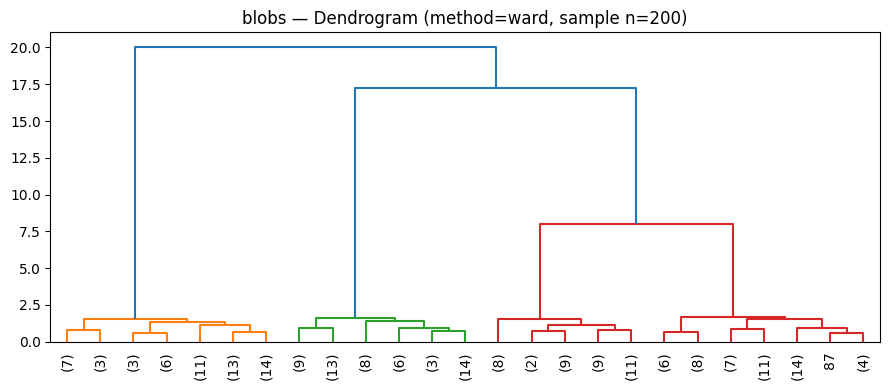

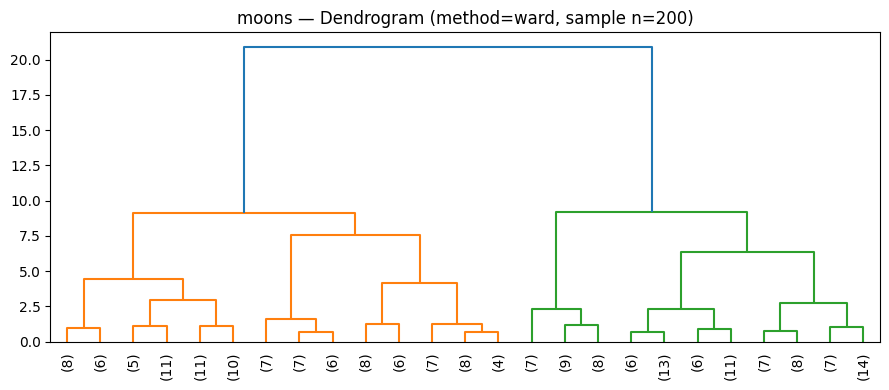

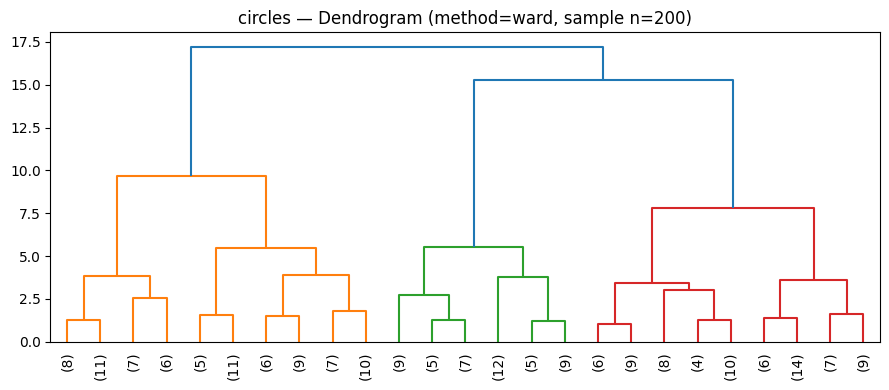

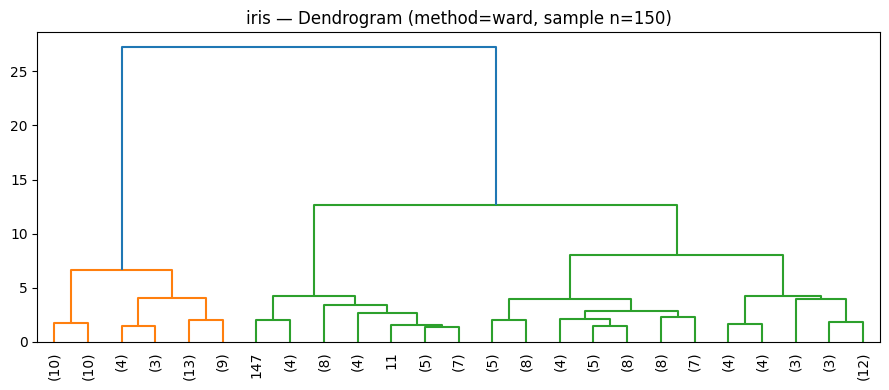

In [3]:
def plot_dendrogram_sample(name, X, method="ward", sample_n=200):
    # skálázás + mintavétel (dendrogram nagy adaton túlzsúfolt)
    Xs = StandardScaler().fit_transform(X)
    idx = np.random.default_rng(42).choice(len(Xs), size=min(sample_n, len(Xs)), replace=False)
    Z = linkage(Xs[idx], method=method)  # 'ward'/'complete'/'average'/'single'

    plt.figure(figsize=(9,4))
    dendrogram(Z, p=25, truncate_mode="lastp", leaf_rotation=90)
    plt.title(f"{name} — Dendrogram (method={method}, sample n={len(idx)})")
    plt.tight_layout(); plt.show()

for name, (X, y, k) in datasets.items():
    # ward dendrogram alapértelmezésben jól szemléltet
    plot_dendrogram_sample(name, X, method="ward", sample_n=200)


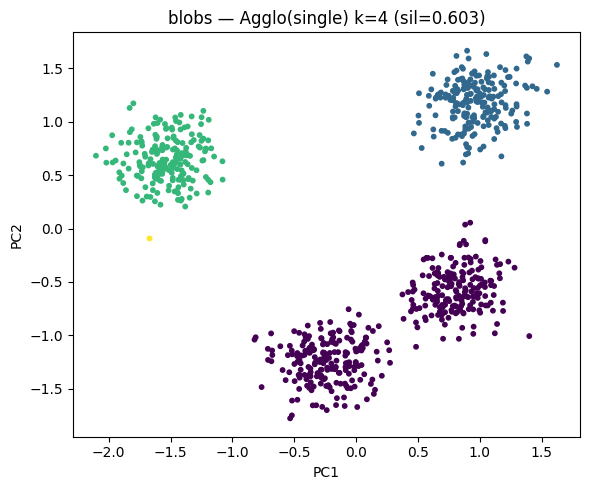

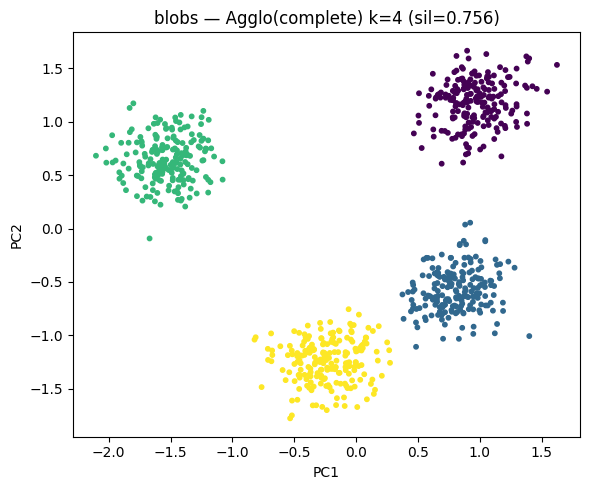

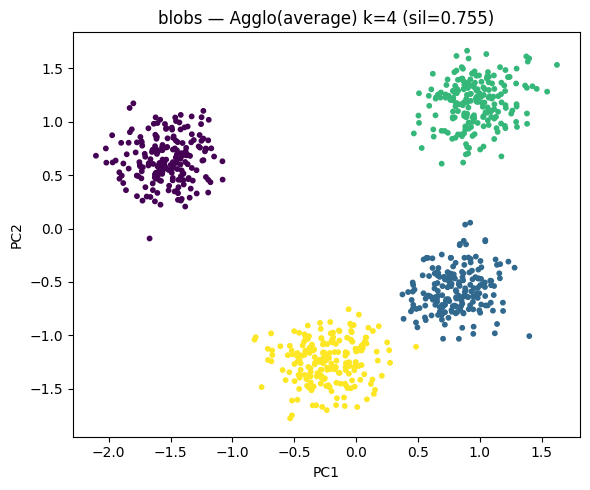

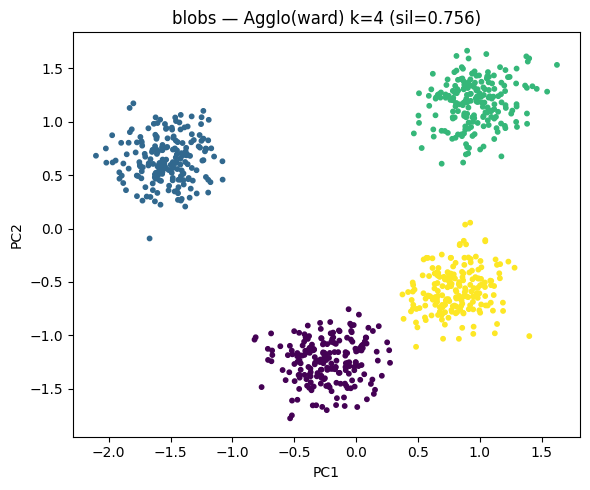

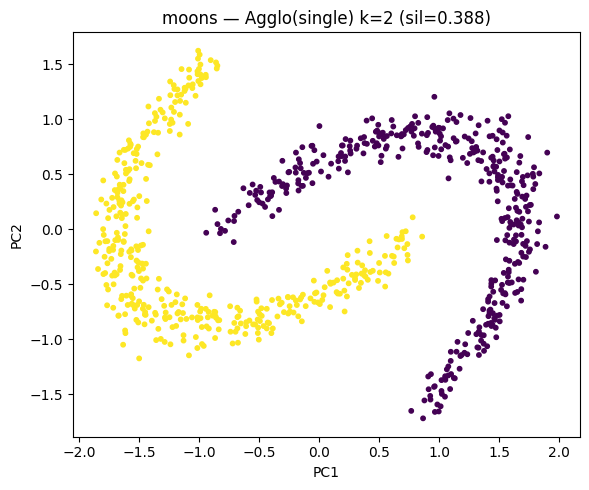

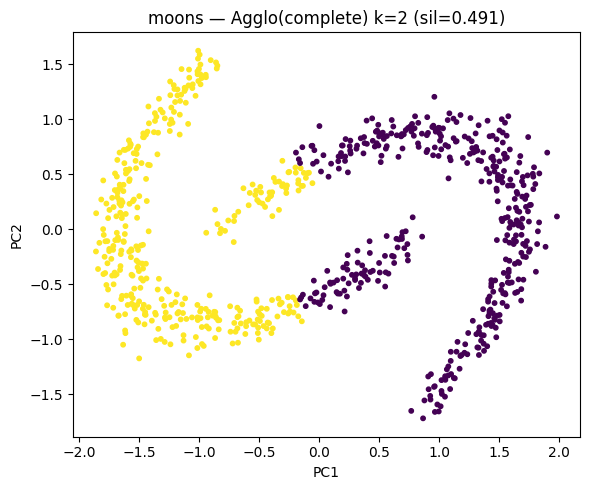

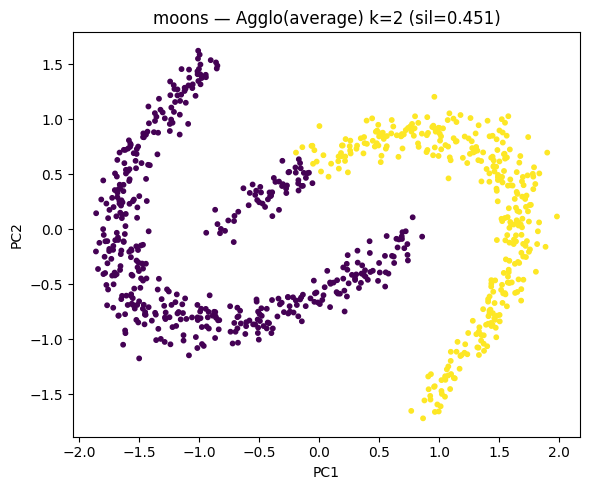

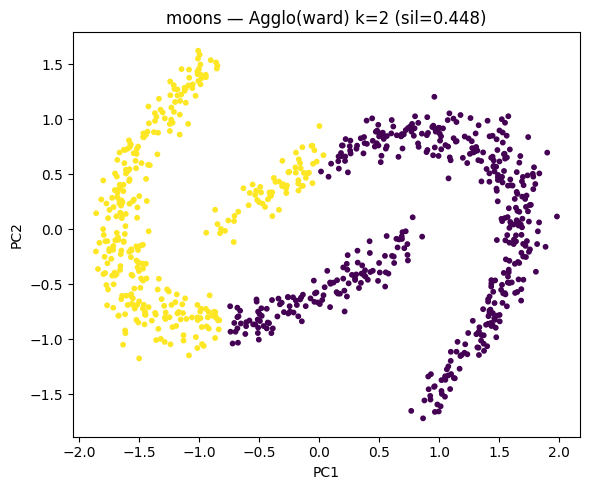

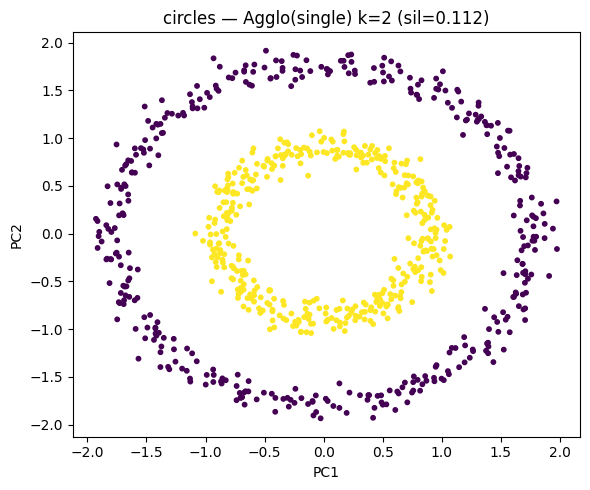

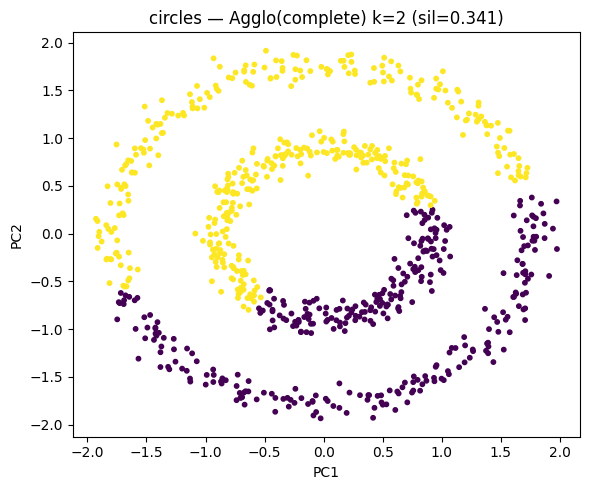

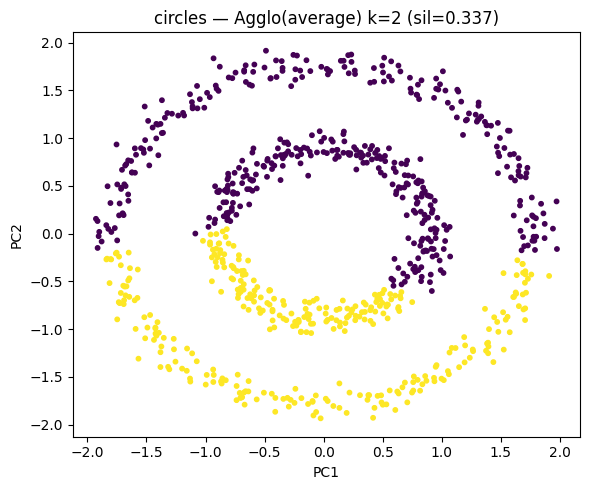

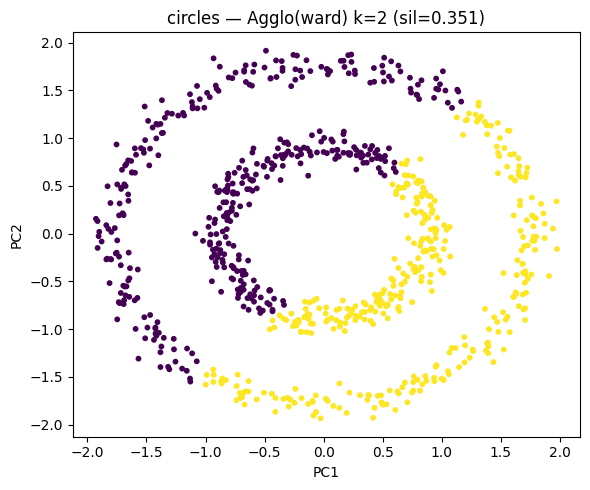

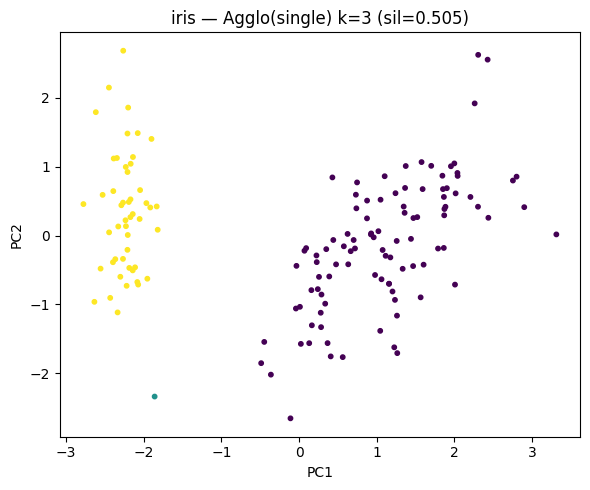

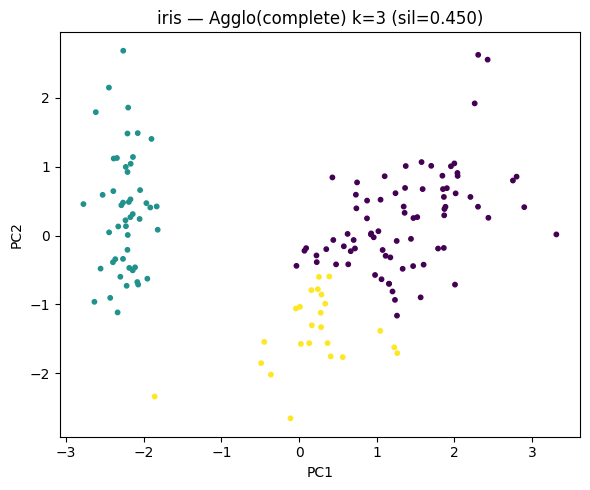

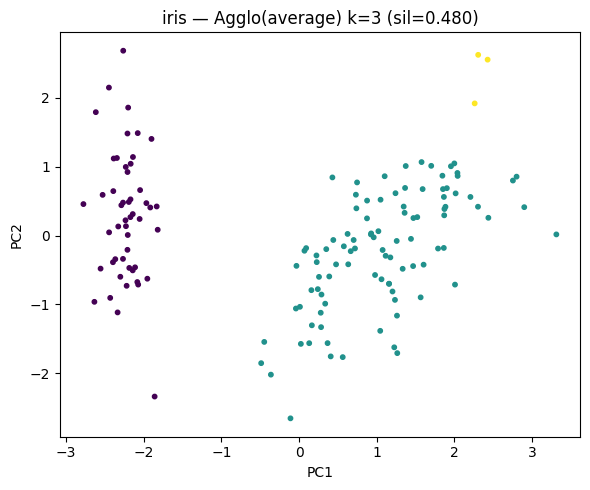

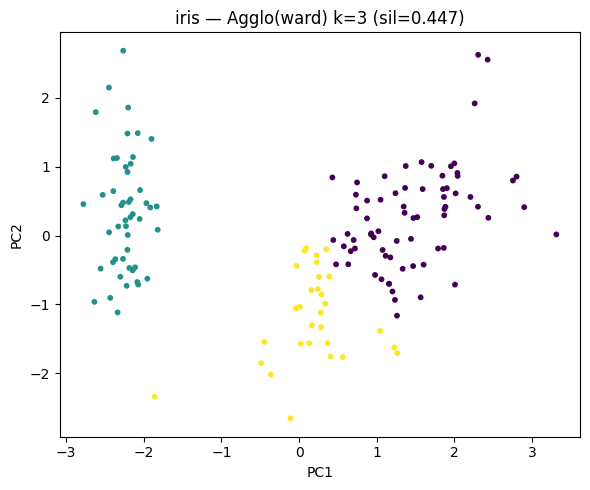

,dataset,linkage,k,sil,db,ch
1,blobs,complete,4,0.755672,0.339428,5937.966481
3,blobs,ward,4,0.755672,0.339428,5937.966481
2,blobs,average,4,0.755193,0.339845,5924.924914
0,blobs,single,4,0.603003,0.386475,1663.516477
11,circles,ward,2,0.350645,1.189087,453.660237
9,circles,complete,2,0.340830,1.210503,432.994295
10,circles,average,2,0.336535,1.214096,424.658039
8,circles,single,2,0.112276,298.112702,0.008068
12,iris,single,3,0.504646,0.492925,131.535896
14,iris,average,3,0.480267,0.575269,149.025799


,dataset,linkage,k,sil,db,ch
0,blobs,complete,4,0.755672,0.339428,5937.966481
1,circles,ward,2,0.350645,1.189087,453.660237
2,iris,single,3,0.504646,0.492925,131.535896
3,moons,complete,2,0.490722,0.813627,1096.914831


In [4]:
all_rows = []
for name, (X, y, k) in datasets.items():
    all_rows += run_on_dataset(name, X, k)

df = pd.DataFrame(all_rows)
display(df.sort_values(["dataset","sil"], ascending=[True, False]))

project_root = os.path.abspath("..")
os.makedirs(os.path.join(project_root, "results", "tables"), exist_ok=True)
out_path = os.path.join(project_root, "results", "tables", "agglomerative.csv")

df.to_csv(out_path, index=False)

# Gyors összegzés: melyik linkage volt a legjobb sil szerinti
best = df.loc[df.groupby("dataset")["sil"].idxmax()].reset_index(drop=True)
best